In [5]:
plt.style.use('ggplot')
color_pal = [x['color'] for x in plt.rcParams['axes.prop_cycle']]

In [67]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns
import plotly.express as px
import plotly.graph_objs as go
from plotly.subplots import make_subplots
import missingno as msno
%matplotlib inline

In [47]:
%pip install seaborn plotly missingno

  Using cached scipy-1.12.0-cp310-cp310-macosx_12_0_arm64.whl (31.4 MB)

[notice] A new release of pip available: 22.3.1 -> 24.0
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [6]:
train_transaction = pd.read_csv('./data/raw/train_transaction.csv')
train_identity = pd.read_csv('./data/raw/train_identity.csv')
test_transaction = pd.read_csv('./data/raw/test_transaction.csv')
test_identity = pd.read_csv('./data/raw/test_identity.csv')

In [7]:
train_transaction = train_transaction.merge(train_identity, how='left', left_index=True, right_index=True)
test_transaction = test_transaction.merge(test_identity, how='left', left_index=True, right_index=True)

In [92]:
train_transaction.head()

,TransactionID_x,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,...,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo,D1n
0,2987000,0,86400,68.5,W,13926,NaN,150.0,discover,142.0,...,32.0,2220x1080,match_status:2,T,F,T,T,mobile,SAMSUNG SM-G892A Build/NRD90M,13.000000
1,2987001,0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,...,32.0,1334x750,match_status:1,T,F,F,T,mobile,iOS Device,-1.000012
2,2987002,0,86469,59.0,W,4663,490.0,150.0,visa,166.0,...,NaN,NaN,NaN,F,F,T,T,desktop,Windows,-1.000799
3,2987003,0,86499,50.0,W,18132,567.0,150.0,mastercard,117.0,...,NaN,NaN,NaN,F,F,T,T,desktop,NaN,110.998854
4,2987004,0,86506,50.0,H,4497,514.0,150.0,mastercard,102.0,...,24.0,1280x800,match_status:2,T,F,T,T,desktop,MacOS,-1.001227


### Distribution of fraud and non fraud labels in dataset

<function matplotlib.pyplot.show(close=None, block=None)>

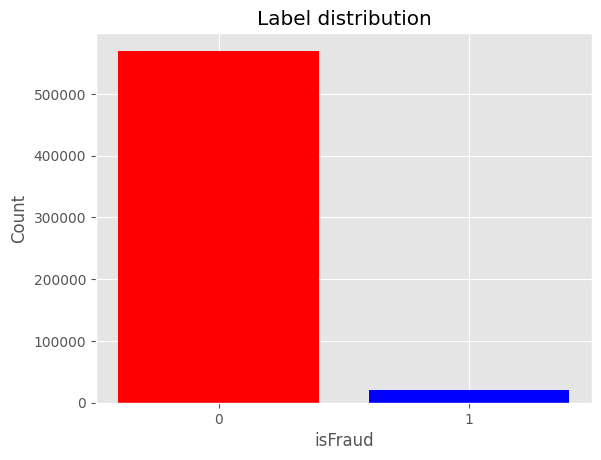

In [9]:
X_train = train_transaction.drop("isFraud", axis=1)
train_transaction["isFraud"] = train_transaction["isFraud"].astype("category")
y_train = train_transaction["isFraud"]



isfraud, count = np.unique(y_train, return_counts=True)
plt.bar(isfraud, count, color=["red", "blue"], tick_label=isfraud)
plt.title("Label distribution")
plt.xlabel("isFraud")
plt.ylabel("Count")
plt.show

In [10]:
# Imbalanced dataset
is_fraud = train_transaction[train_transaction["isFraud"] == 1]
not_fraud = train_transaction[train_transaction["isFraud"] == 0]

# Random under-sampling
length_isfraud = len(is_fraud)
notfraud_undersample = not_fraud.sample(length_isfraud)

train_transaction_undersampled = pd.concat([is_fraud, notfraud_undersample], axis=0)
X_train_undersampled = train_transaction_undersampled.drop("isFraud", axis=1)
y_train_undersampled = train_transaction_undersampled["isFraud"]

This graph suggests that a significant number of transactions are non fradulent, and only a small % of them are fradulent (as one would expect). It should be noted that this dataset is extremely uneven, and to keep this into consideration when we develop our models. We can either perform under or over sampling techniques, or use other metrics such as a precision, recall, and AUC instead of simply accuracy.

### Plotting categorical variable's fraud rate

In [135]:
def plot_fraud(variable, train_transaction):
    variable_df = train_transaction[["isFraud", variable]]
    variable_df.loc[:,variable] = variable_df[variable].fillna(value="NA")
    fraud_rate = variable_df.groupby(variable)["isFraud"].value_counts(normalize=True).unstack()[1]

    p1 = sns.countplot(x=variable, data=variable_df, order=fraud_rate.index)
    p1.set_xlabel("{}".format(variable))

    p2 = p1.twinx()
    p2 = sns.pointplot(x=fraud_rate.index, y=fraud_rate, color="blue")
    p2.set_ylabel("Fraud rate", color="blue")

    plt.show()



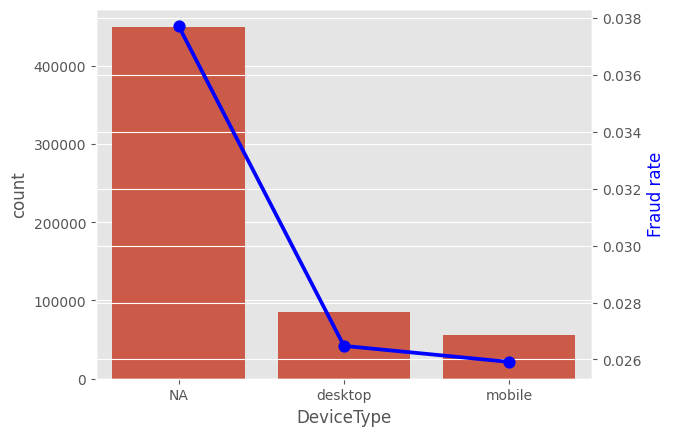

In [136]:
plot_fraud("DeviceType", train_transaction)

### PCA on numerical features
- Transaction amount
- Transaction DT
- dist1
- dist2
- C1 to C14
- D1 to D15


In [ ]:
print(train_transaction["TransactionDT"].head(10))
print(train_transaction["M2"].head(10))

In [12]:
display(train_identity.head())

,TransactionID,id_01,id_02,id_03,id_04,id_05,id_06,id_07,id_08,id_09,...,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
0,2987004,0.0,70787.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,samsung browser 6.2,32.0,2220x1080,match_status:2,T,F,T,T,mobile,SAMSUNG SM-G892A Build/NRD90M
1,2987008,-5.0,98945.0,NaN,NaN,0.0,-5.0,NaN,NaN,NaN,...,mobile safari 11.0,32.0,1334x750,match_status:1,T,F,F,T,mobile,iOS Device
2,2987010,-5.0,191631.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,...,chrome 62.0,NaN,NaN,NaN,F,F,T,T,desktop,Windows
3,2987011,-5.0,221832.0,NaN,NaN,0.0,-6.0,NaN,NaN,NaN,...,chrome 62.0,NaN,NaN,NaN,F,F,T,T,desktop,NaN
4,2987016,0.0,7460.0,0.0,0.0,1.0,0.0,NaN,NaN,0.0,...,chrome 62.0,24.0,1280x800,match_status:2,T,F,T,T,desktop,MacOS


In [13]:
print(train_transaction.columns)

Index(['TransactionID_x', 'isFraud', 'TransactionDT', 'TransactionAmt',
       'ProductCD', 'card1', 'card2', 'card3', 'card4', 'card5',
       ...
       'id_31', 'id_32', 'id_33', 'id_34', 'id_35', 'id_36', 'id_37', 'id_38',
       'DeviceType', 'DeviceInfo'],
      dtype='object', length=435)


In [14]:
train_transaction['D1n'] =  train_transaction['D1'] -   train_transaction.TransactionDT/np.float32(24*60*60)

## Missing Values in Columns

In [15]:
#Can remove columns with 90% missing values

def top_missing_cols(df,n=10,thresh=90):
    """
    returns missing columns in dataframe with missing values percent > thresh
    if n=None. It will gave whole dataframe with missing values percent > thresh
    """
    
    dff = (df.isnull().sum()/df.shape[0])*100
    dff = dff.reset_index()
    dff.columns = ['col','missing_percent']
    dff = dff.sort_values(by=['missing_percent'],ascending=False).reset_index(drop=True)
    print(f'There are {df.isnull().any().sum()} columns in this dataset with missing values.')
    print(f'There are {dff[dff["missing_percent"] > thresh].shape[0]} columns with missing percent values than {thresh}%')
    if n:
        return dff.head(n)
    else:
        return dff

In [34]:
top_missing_cols(train_transaction, n = 12, thresh=90)

There are 416 columns in this dataset with missing values.
There are 12 columns with missing percent values than 90%


,col,missing_percent
0,id_24,99.196159
1,id_25,99.130965
2,id_07,99.127070
3,id_08,99.127070
4,id_21,99.126393
5,id_26,99.125715
6,id_27,99.124699
7,id_23,99.124699
8,id_22,99.124699
9,dist2,93.628374


## TransactionDT distribution

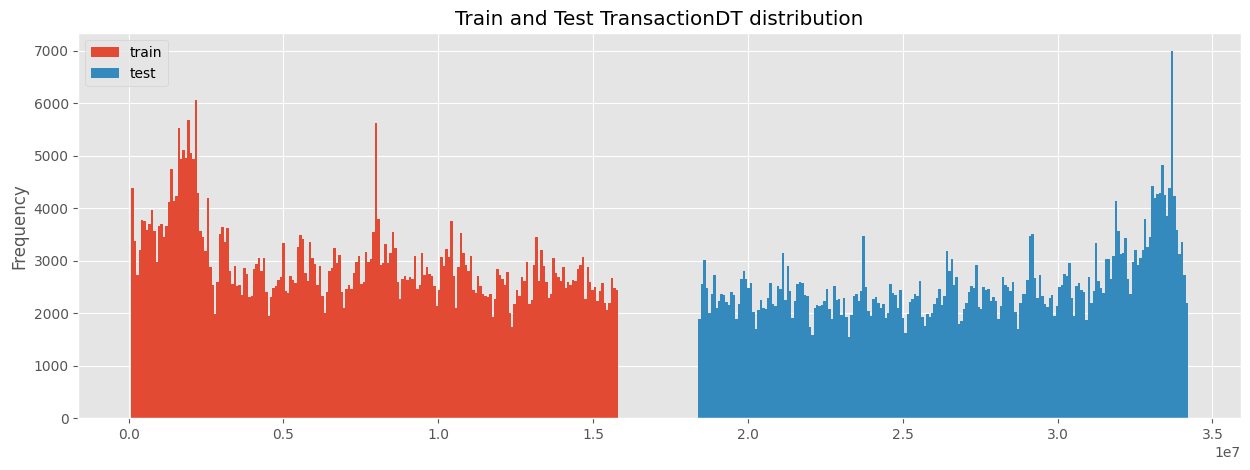

In [17]:
train_transaction['TransactionDT'].plot(kind='hist', figsize=(15, 5), label='train', bins=200, title='Train and Test TransactionDT distribution')
test_transaction['TransactionDT'].plot(kind='hist', label='test', bins=200)
plt.legend()
plt.show()

As TransactionDT is defined as the time delta of the transaction, we can deduce that the training and test datasets are split by time. This may potentially impact any cross validation techniques.

<Axes: title={'center': 'Test Log Transaction Amt'}, ylabel='Frequency'>

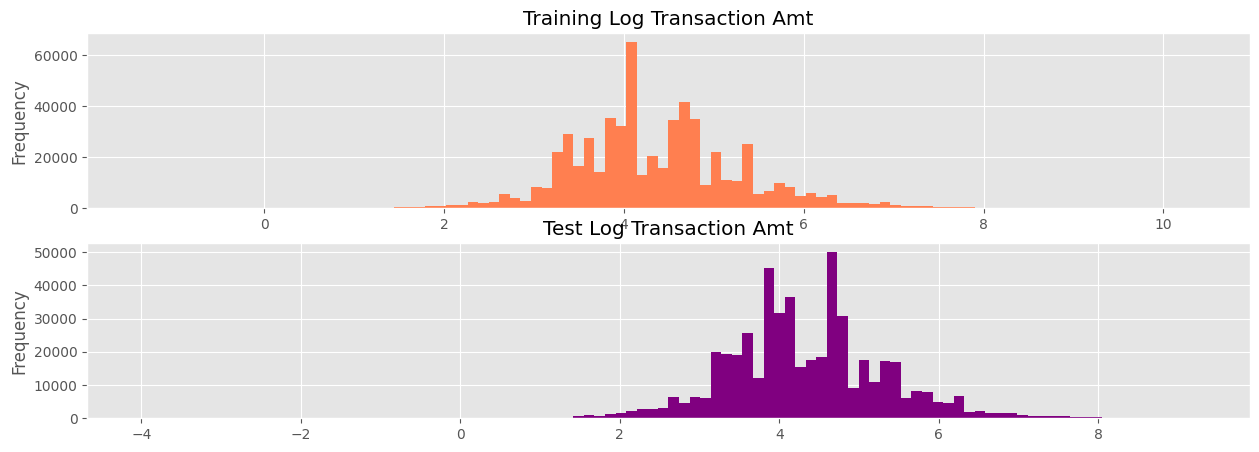

In [19]:
fig, ((ax1, ax2)) = plt.subplots(2, 1, figsize=(15, 6))
train_transaction['TransactionAmt']\
    .apply(np.log)\
        .plot(kind='hist', 
              figsize=(15, 5), 
              label='train', 
              bins=100, 
              title='Training Log Transaction Amt',
              color='coral',
              ax=ax1)

test_transaction['TransactionAmt']\
    .apply(np.log)\
        .plot(kind='hist', 
              figsize=(15, 5), 
              label='train', 
              bins=100, 
              title='Test Log Transaction Amt',
              color='purple',
              ax=ax2)

## Distribution of TransactionAmt grouped by isFraud

<Axes: title={'center': 'Log Transaction Amt - No Fraud'}, ylabel='Frequency'>

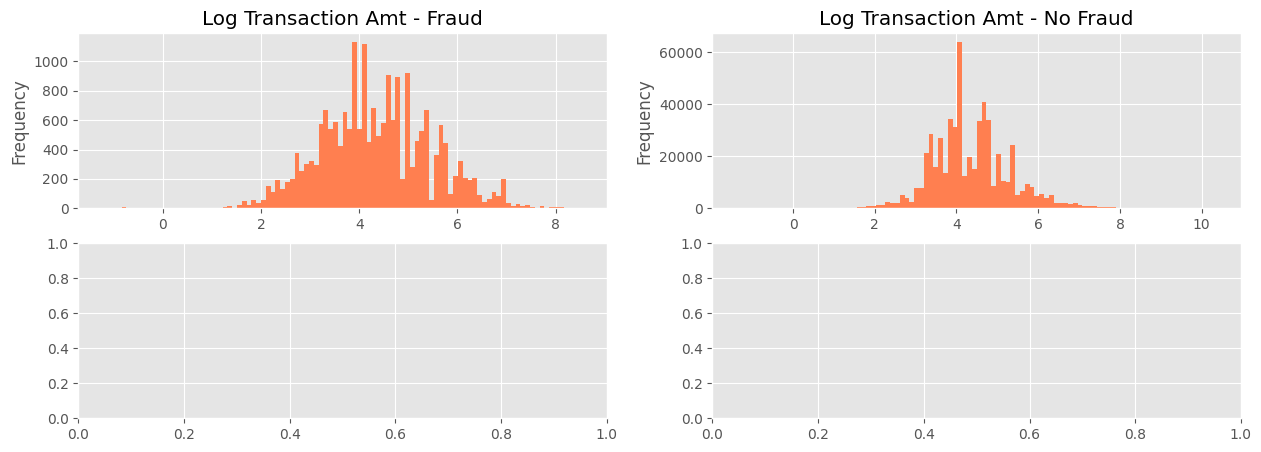

In [41]:
# now we split by fraud and no fraud
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 6))
train_transaction[train_transaction['isFraud'] == 1]['TransactionAmt']\
    .apply(np.log)\
        .plot(kind='hist', 
              figsize=(15, 5), 
              label='Fraud', 
              bins=100, 
              title='Log Transaction Amt - Fraud',
              color='coral',
              ax=ax1)

train_transaction[train_transaction['isFraud'] == 0]['TransactionAmt']\
    .apply(np.log)\
        .plot(kind='hist', 
              figsize=(15, 5), 
              label='No Fraud', 
              bins=100, 
              title='Log Transaction Amt - No Fraud',
              color='coral',
              ax=ax2)

# test_transaction[test_transaction['isFraud'] == 1]['TransactionAmt']\
#     .apply(np.log)\
#         .plot(kind='hist', 
#               figsize=(15, 5), 
#               label='Fraud', 
#               bins=100, 
#               title='Log Transaction Amt - Fraud',
#               color='purple',
#               ax=ax3)

# test_transaction[test_transaction['isFraud'] == 0]['TransactionAmt']\
#     .apply(np.log)\
#         .plot(kind='hist', 
#               figsize=(15, 5), 
#               label='No Fraud', 
#               bins=100, 
#               title='Log Transaction Amt - No Fraud',
#               color='purple',
#               ax=ax4)

<Axes: title={'center': 'Test TransactionAmt distribution'}, ylabel='Frequency'>

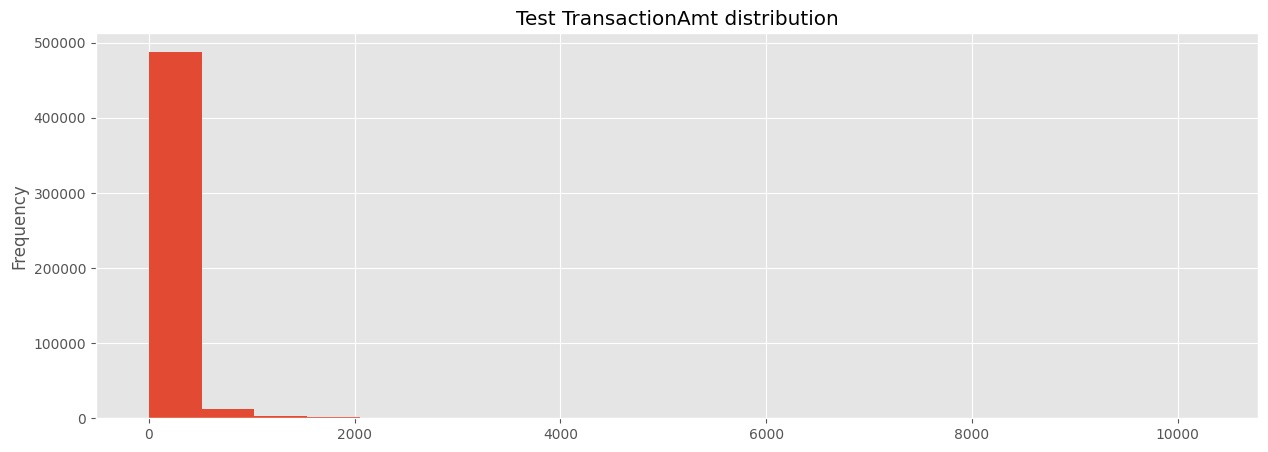

In [22]:
test_transaction['TransactionAmt'].plot(kind='hist', figsize=(15, 5), label='test', bins=20, title='Test TransactionAmt distribution')

In [23]:
Ds = ["D" + str(x) for x in range(1,16)]
Ds.append("TransactionDT")
# print(Ds)
train_transaction[Ds]

,D1,D2,D3,D4,D5,D6,D7,D8,D9,D10,D11,D12,D13,D14,D15,TransactionDT
0,14.0,NaN,13.0,NaN,NaN,NaN,NaN,NaN,NaN,13.0,13.0,NaN,NaN,NaN,0.0,86400
1,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,0.0,86401
2,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,0.0,315.0,NaN,NaN,NaN,315.0,86469
3,112.0,112.0,0.0,94.0,0.0,NaN,NaN,NaN,NaN,84.0,NaN,NaN,NaN,NaN,111.0,86499
4,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,86506
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
590535,29.0,29.0,30.0,NaN,NaN,NaN,NaN,NaN,NaN,56.0,56.0,NaN,NaN,NaN,56.0,15811047
590536,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,0.0,15811049
590537,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,0.0,15811079
590538,22.0,22.0,0.0,22.0,0.0,NaN,NaN,NaN,NaN,22.0,22.0,NaN,NaN,NaN,22.0,15811088


In [24]:
train_transaction['D1'] - train_transaction.TransactionDT/np.float32(24*60*60)

0          13.000000
1          -1.000012
2          -1.000799
3         110.998854
4          -1.001227
             ...    
590535   -153.998229
590536   -182.998252
590537   -182.998600
590538   -160.998704
590539   -182.999201
Length: 590540, dtype: float64

In [26]:
def high_correlation(df, col_start, col_end, threshold):
    corr = df.loc[:, col_start:col_end].corr()
    # print(corr[corr>0.9])
    # if > threshold: suggest remove
    cols = corr.columns
    res = set()
    for i in range(len(cols)):
        for j in range(i+1, len(cols)):
            if corr.iloc[i, j] > threshold:
                res.add(cols[j])
    return res

subsets = [("C1", "C14"), ("D1", "D15"), ("M1", "M9"), ("V1", "V339")]
for subset in subsets:
    print(high_correlation(train_transaction, subset[0], subset[1], 0.9))

{'C6', 'C7', 'C8', 'C14', 'C10', 'C4', 'C11', 'C12', 'C9', 'C2'}


KeyError: 'D'

In [27]:
print(train_transaction.columns.tolist())

['TransactionID_x', 'isFraud', 'TransactionDT', 'TransactionAmt', 'ProductCD', 'card1', 'card2', 'card3', 'card4', 'card5', 'card6', 'addr1', 'addr2', 'dist1', 'dist2', 'P_emaildomain', 'R_emaildomain', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9', 'C10', 'C11', 'C12', 'C13', 'C14', 'D1', 'D2', 'D3', 'D4', 'D5', 'D6', 'D7', 'D8', 'D9', 'D10', 'D11', 'D12', 'D13', 'D14', 'D15', 'M1', 'M2', 'M3', 'M4', 'M5', 'M6', 'M7', 'M8', 'M9', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'V29', 'V30', 'V31', 'V32', 'V33', 'V34', 'V35', 'V36', 'V37', 'V38', 'V39', 'V40', 'V41', 'V42', 'V43', 'V44', 'V45', 'V46', 'V47', 'V48', 'V49', 'V50', 'V51', 'V52', 'V53', 'V54', 'V55', 'V56', 'V57', 'V58', 'V59', 'V60', 'V61', 'V62', 'V63', 'V64', 'V65', 'V66', 'V67', 'V68', 'V69', 'V70', 'V71', 'V72', 'V73', 'V74', 'V75', 'V76', 'V77', 'V78', 'V79', 'V80', 'V81', 

In [28]:
'''
Hypothesis: To identify users, possible features to use: 
"card1": "card6", 
"addr1", "addr2",
P_emaildomain
R_emaildomain
'''
train_transaction.loc[:, "M1":"M9"]

,M1,M2,M3,M4,M5,M6,M7,M8,M9
0,T,T,T,M2,F,T,NaN,NaN,NaN
1,NaN,NaN,NaN,M0,T,T,NaN,NaN,NaN
2,T,T,T,M0,F,F,F,F,F
3,NaN,NaN,NaN,M0,T,F,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...
590535,T,T,T,M0,T,F,F,F,T
590536,T,F,F,M0,F,T,F,F,F
590537,T,F,F,NaN,NaN,T,NaN,NaN,NaN
590538,T,T,T,M0,F,T,NaN,NaN,NaN


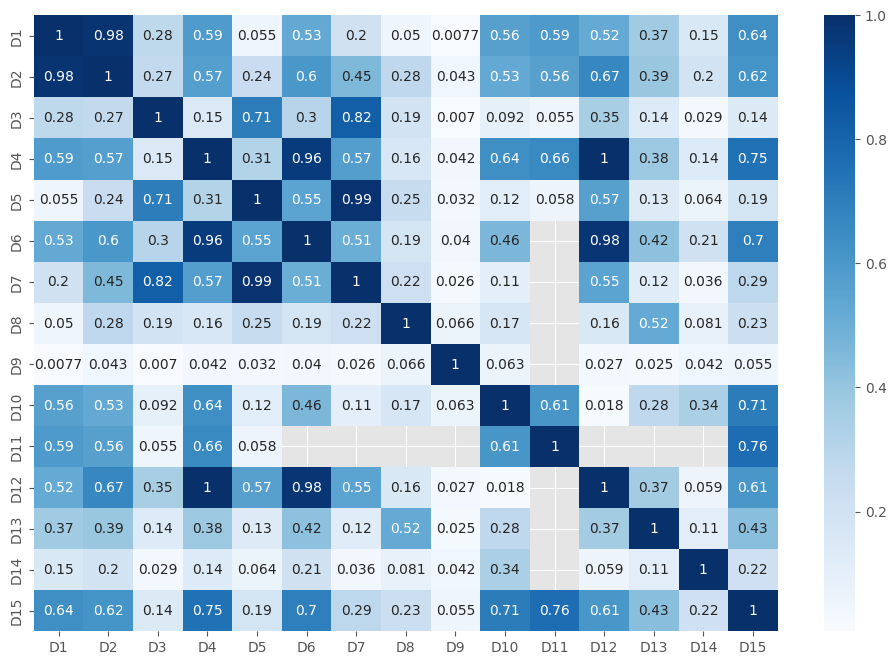

In [29]:
%matplotlib inline
corr = train_transaction.loc[:, "D1":"D15"].corr()

plt.figure(figsize=(12,8))
sns.heatmap(corr, cmap="Blues", annot=True)
plt.show()

In [30]:
card_cols = [c for c in train_transaction.columns if 'card' in c]
train_transaction[card_cols].head()

,card1,card2,card3,card4,card5,card6
0,13926,NaN,150.0,discover,142.0,credit
1,2755,404.0,150.0,mastercard,102.0,credit
2,4663,490.0,150.0,visa,166.0,debit
3,18132,567.0,150.0,mastercard,117.0,debit
4,4497,514.0,150.0,mastercard,102.0,credit


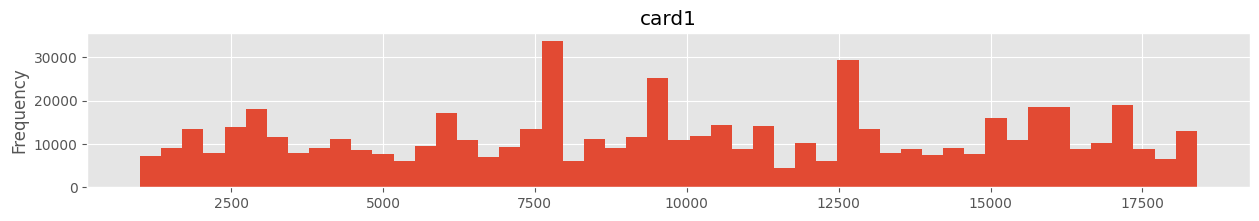

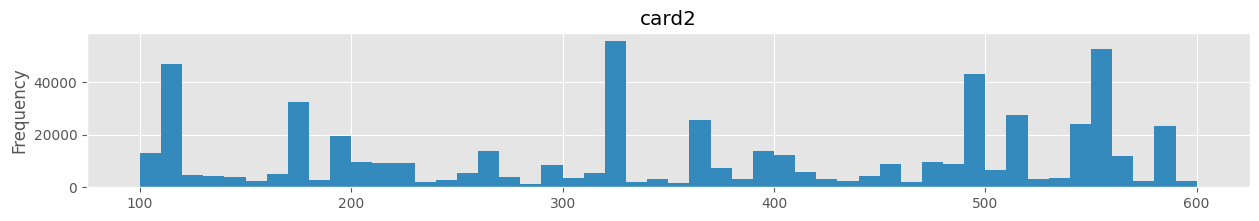

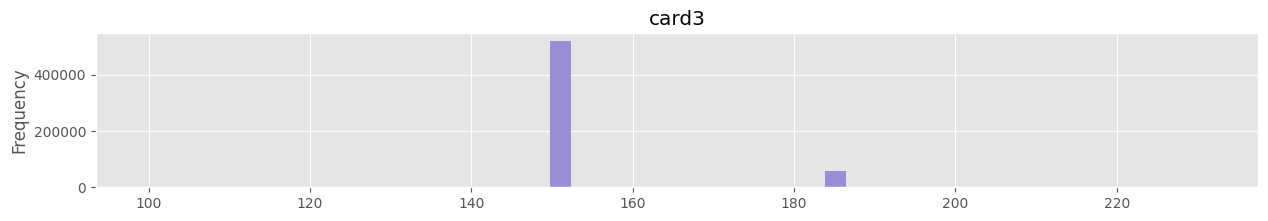

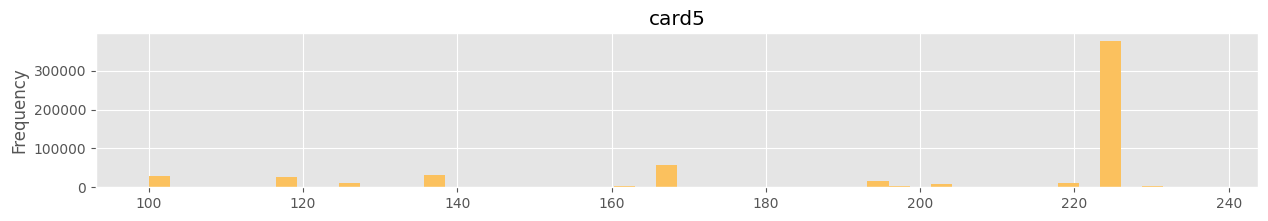

In [31]:
color_idx = 0
for c in card_cols:
    if train_transaction[c].dtype in ['float64','int64']:
        train_transaction[c].plot(kind='hist',
                                      title=c,
                                      bins=50,
                                      figsize=(15, 2),
                                      color=color_pal[color_idx])
    color_idx += 1
    plt.show()

,TransactionID,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,...,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339
0,2987000,86400,68.5,W,13926,NaN,150.0,discover,142.0,credit,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2987001,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,credit,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2987002,86469,59.0,W,4663,490.0,150.0,visa,166.0,debit,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2987003,86499,50.0,W,18132,567.0,150.0,mastercard,117.0,debit,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2987004,86506,50.0,H,4497,514.0,150.0,mastercard,102.0,credit,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [33]:
train_transaction['TransactionAmt'] = train_transaction['TransactionAmt'].astype(float)
print("Transaction Amounts Quantiles:")
print(train_transaction['TransactionAmt'].quantile([.01, .025, .1, .25, .5, .75, .9, .975, .99]))


Transaction Amounts Quantiles:
0.010       9.2440
0.025      14.5010
0.100      25.9500
0.250      43.3210
0.500      68.7690
0.750     125.0000
0.900     275.2930
0.975     648.3345
0.990    1104.0000
Name: TransactionAmt, dtype: float64


<Axes: xlabel='isFraud'>

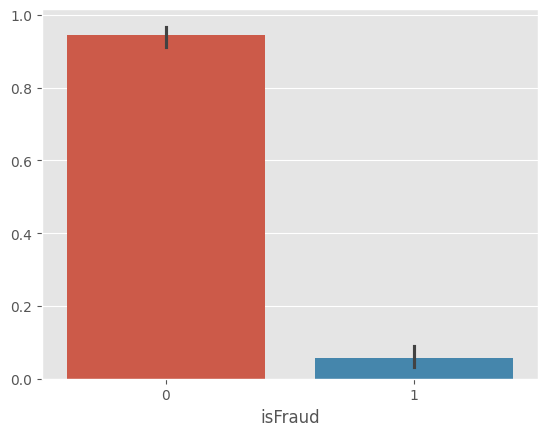

In [59]:
sns.barplot(train_transaction.groupby("ProductCD")["isFraud"].value_counts(normalize=True).unstack())

In [35]:
print('Number of row in transaction:', len(train_transaction))
print('Number of row in identity:', len(train_identity))


Number of row in transaction: 590540
Number of row in identity: 144233


<Axes: >

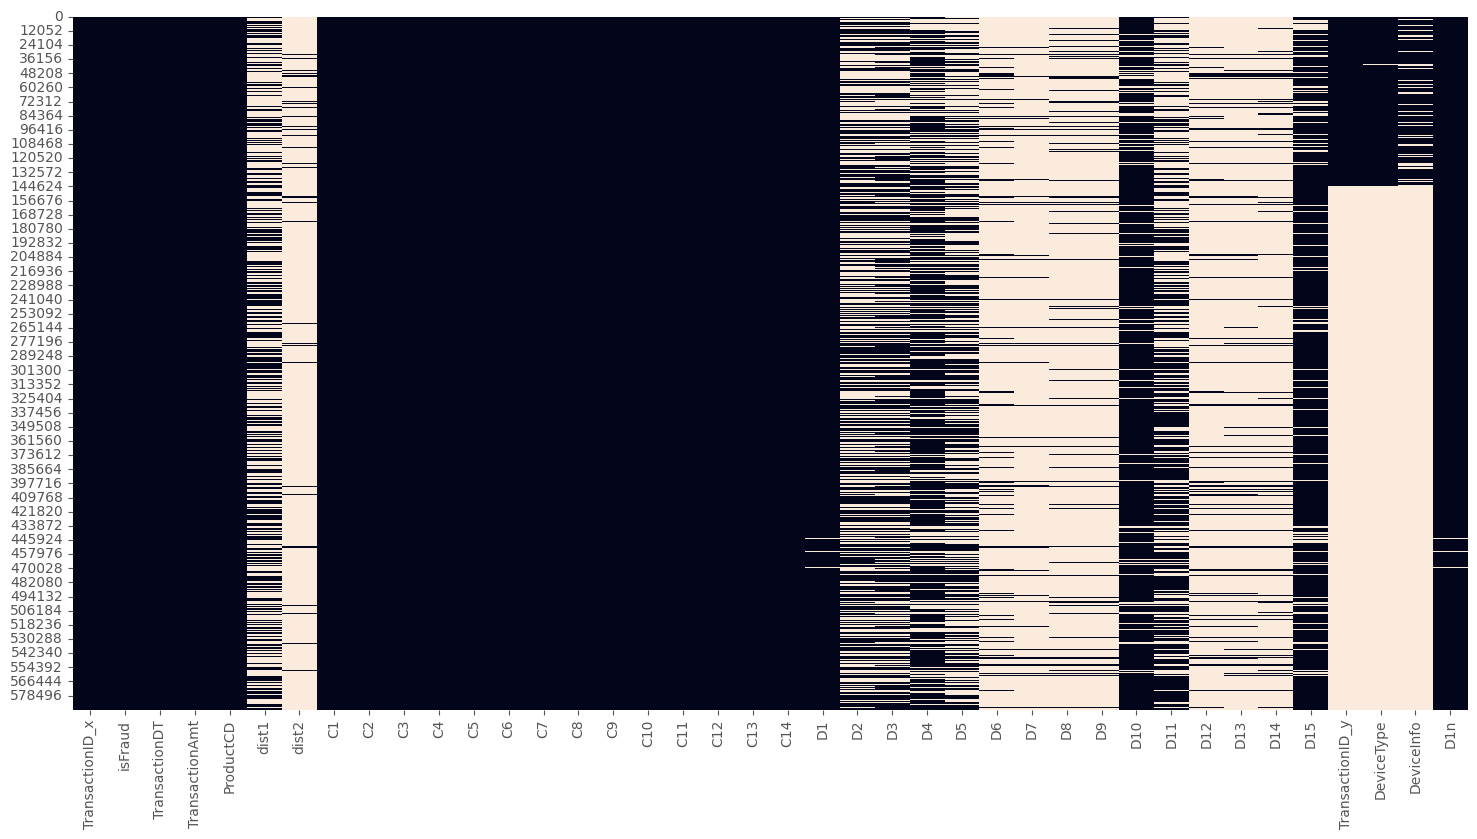

In [43]:
train_transaction_num = train_transaction.filter(regex='isFraud|TransactionDT|TransactionAmt|dist|C|D')
plt.figure(figsize=(18,9))
sns.heatmap(train_transaction_num.isnull(), cbar= False)

<Axes: >

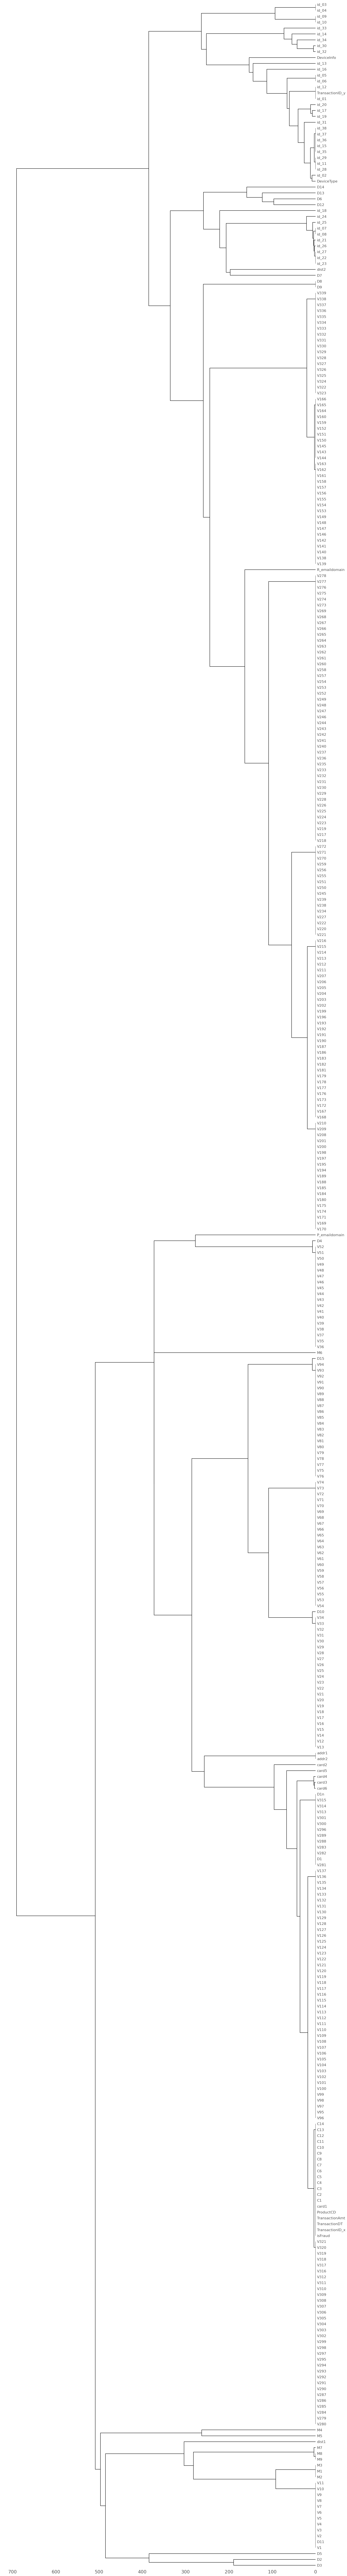

In [50]:
msno.dendrogram(train_transaction)

In [63]:
train_transaction_categorical = train_transaction.filter(regex='id|card|ProductCD|addr|email|M|DeviceType|DeviceInfo|isFraud')


In [64]:
print(train_transaction_categorical.head())

  isFraud ProductCD  card1  card2  card3       card4  card5   card6  addr1  \
0       0         W  13926    NaN  150.0    discover  142.0  credit  315.0   
1       0         W   2755  404.0  150.0  mastercard  102.0  credit  325.0   
2       0         W   4663  490.0  150.0        visa  166.0   debit  330.0   
3       0         W  18132  567.0  150.0  mastercard  117.0   debit  476.0   
4       0         H   4497  514.0  150.0  mastercard  102.0  credit  420.0   

   addr2  ...                id_31 id_32      id_33           id_34 id_35  \
0   87.0  ...  samsung browser 6.2  32.0  2220x1080  match_status:2     T   
1   87.0  ...   mobile safari 11.0  32.0   1334x750  match_status:1     T   
2   87.0  ...          chrome 62.0   NaN        NaN             NaN     F   
3   87.0  ...          chrome 62.0   NaN        NaN             NaN     F   
4   87.0  ...          chrome 62.0  24.0   1280x800  match_status:2     T   

  id_36 id_37 id_38 DeviceType                     DeviceInfo  
0   

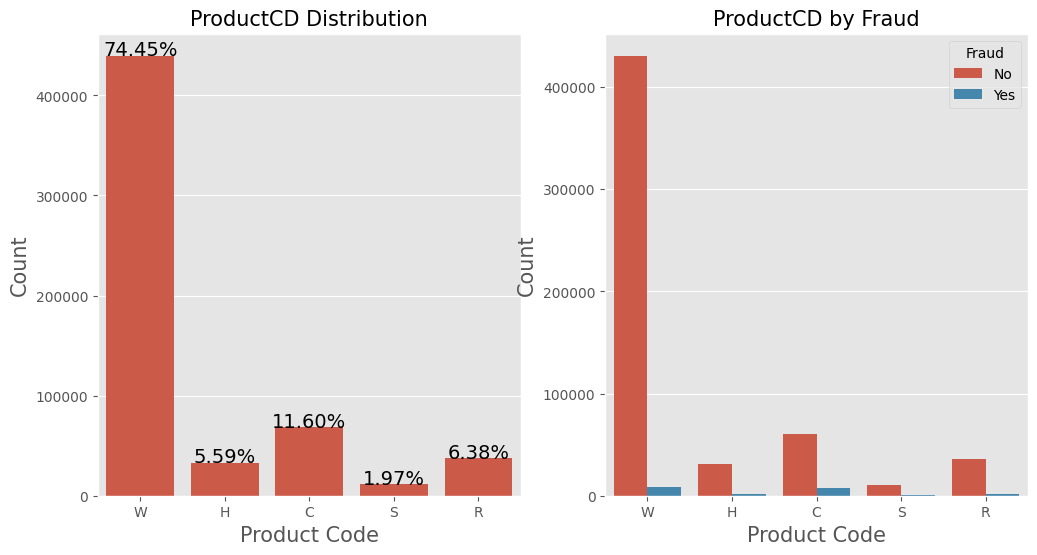

In [72]:
plt.figure(figsize=(12,6))

total = len(train_transaction_categorical)

plt.subplot(121)
g = sns.countplot(x = 'ProductCD', data = train_transaction_categorical)
g.set_title('ProductCD Distribution', fontsize = 15)
g.set_xlabel("Product Code", fontsize=15)
g.set_ylabel("Count", fontsize=15)
for p in g.patches:
    height = p.get_height()
    g.text(p.get_x()+p.get_width()/2.,
            height + 3,
            '{:1.2f}%'.format(height/total*100),
            ha="center", fontsize=14) 

plt.subplot(122)
g1 = sns.countplot(x='ProductCD', hue='isFraud', data=train_transaction_categorical)
g1.set_title('ProductCD by Fraud', fontsize = 15)
g1.set_xlabel("Product Code", fontsize=15)
g1.set_ylabel("Count", fontsize=15)
plt.legend(title='Fraud', loc='best', labels=['No', 'Yes'])

plt.show()

## By Card Network

In [128]:
def fraud_by_category(category, category_name):
    plt.figure(figsize=(12,6))

    total = len(train_transaction)

    plt.subplot(121)
    g = sns.countplot(x = category, data = train_transaction)
    g.set_title(category_name + ' Distribution', fontsize = 15)
    g.set_xlabel("Card Issuers", fontsize=15)
    g.set_ylabel("Count", fontsize=15)
    for p in g.patches:
        height = p.get_height()
        g.text(p.get_x()+p.get_width()/2.,
                height + 10,
                '{:1.2f}%'.format(height/total*100),
                ha="center", fontsize=14) 

    plt.subplot(122)
    g1 = sns.countplot(x=category, hue='isFraud', data=train_transaction)
    g1.set_title(category_name + ' by Fraud', fontsize = 15)
    g1.set_xlabel("Card Issuers", fontsize=15)
    g1.set_ylabel("Count", fontsize=15)
    plt.legend(title='Fraud', loc='best', labels=['No', 'Yes'])

    # visualization of table
    plt.figure(figsize=(12,12))
    b = train_transaction.groupby(category)['isFraud'].value_counts(normalize = True).unstack().plot.bar(stacked = True)
    b.set_title('Rate of Fraud by ' + category_name, fontsize = 15)
    plt.xticks(rotation='horizontal')
    plt.legend(title="Fraud", loc="lower right", labels=["No", "Yes"])

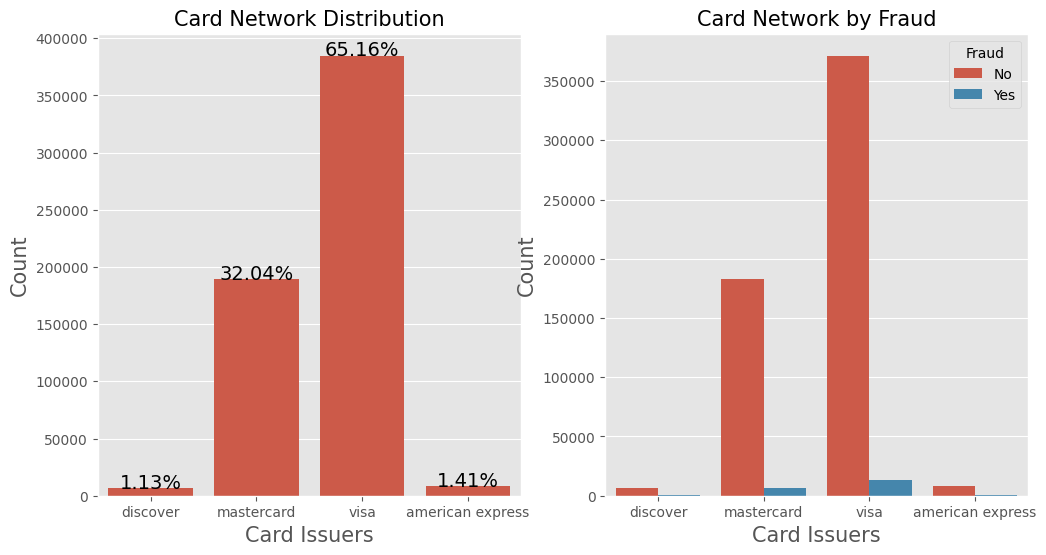

<Figure size 1200x1200 with 0 Axes>

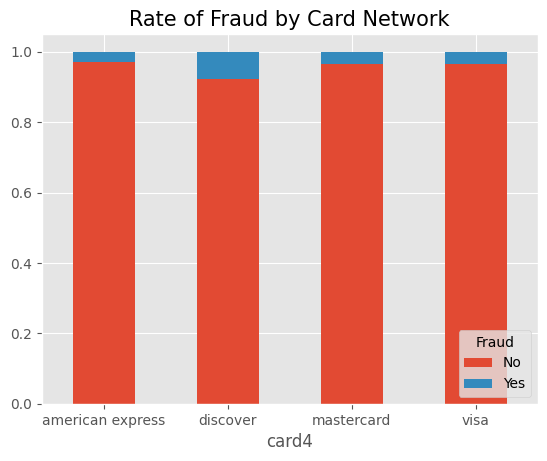

In [129]:
fraud_by_category("card4", "Card Network")

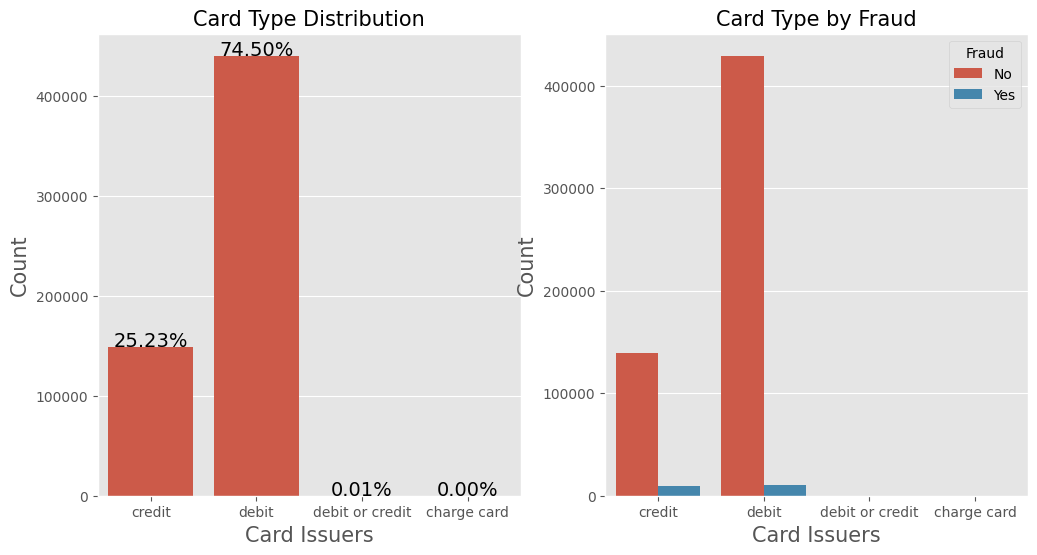

<Figure size 1200x1200 with 0 Axes>

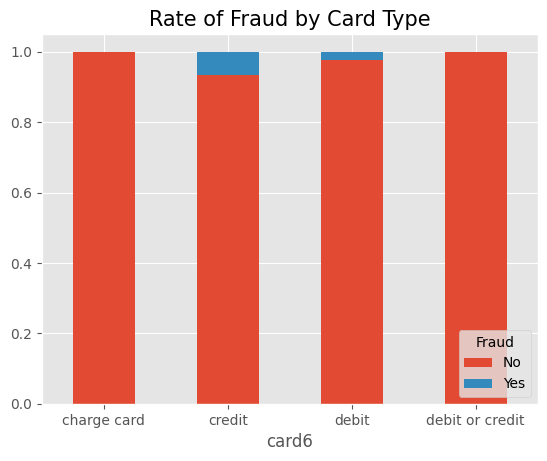

In [130]:
fraud_by_category("card6", "Card Type")

## By Purchaser and Recipient Email

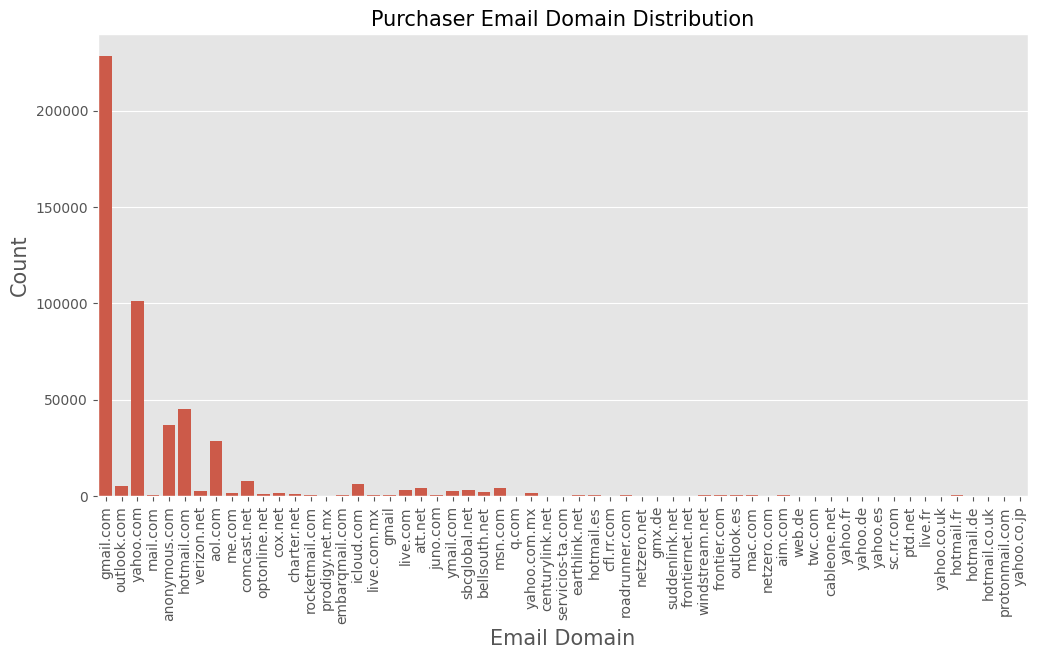

In [141]:
plt.figure(figsize=(12,6))

g = sns.countplot(x = 'P_emaildomain', data = train_transaction)
g.set_title('Purchaser Email Domain Distribution', fontsize = 15)
g.set_xlabel("Email Domain", fontsize=15)
g.set_ylabel("Count", fontsize=15)
plt.xticks(rotation='vertical')
plt.show()

In [143]:
emails = train_transaction[["isFraud", "P_emaildomain", "R_emaildomain"]]
emails["P_parent_emaildomain"] = emails["P_emaildomain"].str.split(".", expand=True)[0]
emails["R_parent_emaildomain"] = emails["R_emaildomain"].str.split(".", expand=True)[0]

/var/folders/8b/n4frqn8n3f927hpnmlxv1dlr0000gp/T/ipykernel_22143/1300069136.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  emails["P_parent_emaildomain"] = emails["P_emaildomain"].str.split(".", expand=True)[0]
/var/folders/8b/n4frqn8n3f927hpnmlxv1dlr0000gp/T/ipykernel_22143/1300069136.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  emails["R_parent_emaildomain"] = emails["R_emaildomain"].str.split(".", expand=True)[0]


In [145]:
plt.figure(figsize=(12,6))

g = sns.countplot(x = 'P_parent_emaildomain', data = train_full)
g.set_title('Purchaser Email Domain Distribution', fontsize = 15)
g.set_xlabel("Email Domain", fontsize=15)
g.set_ylabel("Count", fontsize=15)
plt.xticks(rotation= "vertical")
plt.show()

,isFraud,P_emaildomain,R_emaildomain,P_parent_emaildomain,R_parent_emaildomain
0,0,NaN,NaN,NaN,NaN
1,0,gmail.com,NaN,gmail,NaN
2,0,outlook.com,NaN,outlook,NaN
3,0,yahoo.com,NaN,yahoo,NaN
4,0,gmail.com,NaN,gmail,NaN
...,...,...,...,...,...
590535,0,NaN,NaN,NaN,NaN
590536,0,gmail.com,NaN,gmail,NaN
590537,0,gmail.com,NaN,gmail,NaN
590538,0,aol.com,NaN,aol,NaN


In [96]:
train_transaction[train_transaction['isFraud'] == 1]['ProductCD'].value_counts(normalize = True)

ProductCD
W    0.434061
C    0.387553
H    0.076175
R    0.069012
S    0.033199
Name: proportion, dtype: float64

In [77]:
train_transaction.groupby('ProductCD')['isFraud'].value_counts(normalize = True)

ProductCD  isFraud
C          0          0.883127
           1          0.116873
H          0          0.952338
           1          0.047662
R          0          0.962174
           1          0.037826
S          0          0.941004
           1          0.058996
W          0          0.979601
           1          0.020399
Name: proportion, dtype: float64

(array([0, 1, 2, 3, 4]),
 [Text(0, 0, 'C'),
  Text(1, 0, 'H'),
  Text(2, 0, 'R'),
  Text(3, 0, 'S'),
  Text(4, 0, 'W')])

<Figure size 1200x1200 with 0 Axes>

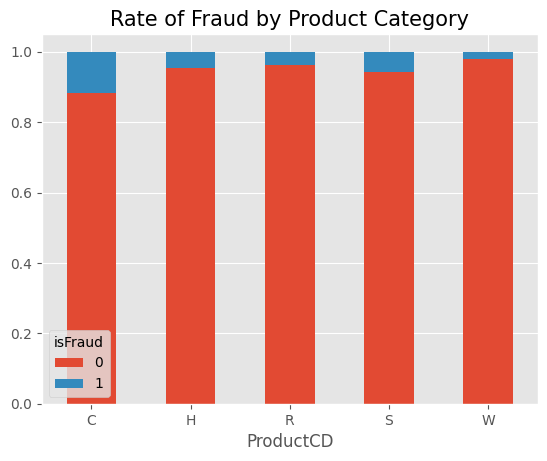

In [83]:

plt.figure(figsize=(12,12))
a = train_transaction.groupby('ProductCD')['isFraud'].value_counts(normalize = True).unstack().plot.bar(stacked = True)
a.set_title('Rate of Fraud by Product Category', fontsize = 15)
plt.xticks(rotation='horizontal')

<Axes: xlabel='ProductCD', ylabel='TransactionAmt'>

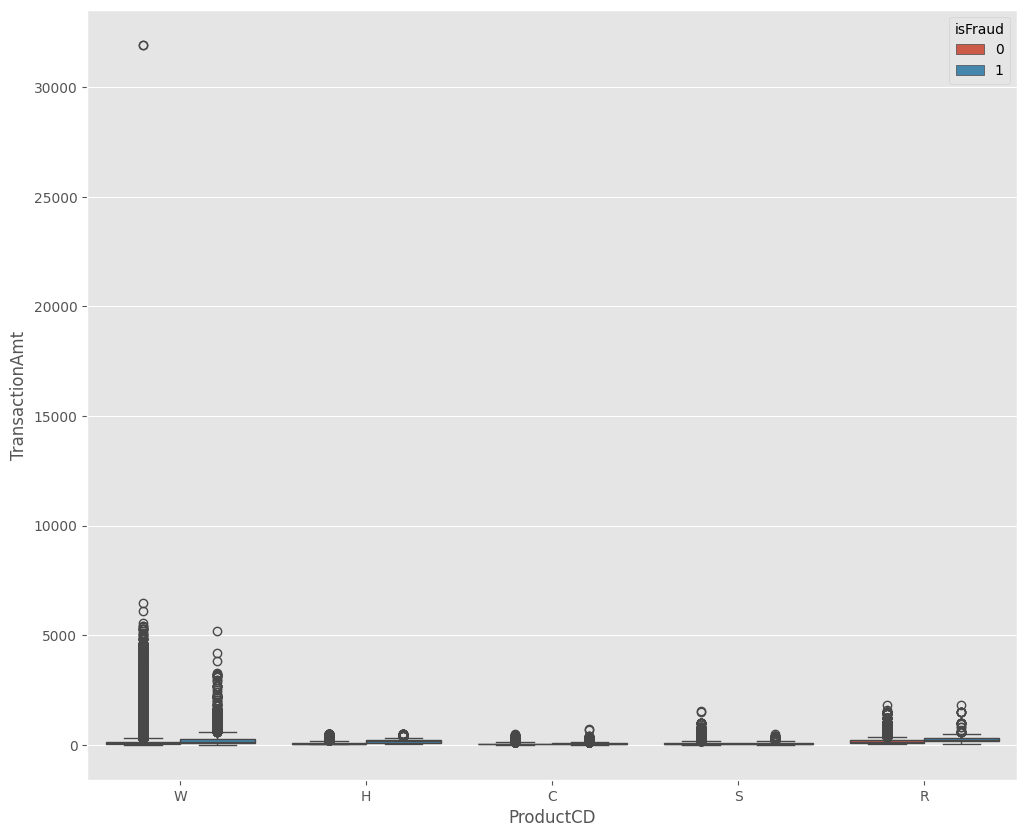

In [115]:
plt.figure(figsize=(12,10))
sns.boxplot(x = 'ProductCD', y = 'TransactionAmt', hue = 'isFraud', data = train_transaction)

In [139]:
train_transaction_categorical.describe().loc[:,'card1':'card5']

,card1,card2,card3,card5
count,590540.000000,581607.000000,588975.000000,586281.000000
mean,9898.734658,362.555488,153.194925,199.278897
std,4901.170153,157.793246,11.336444,41.244453
min,1000.000000,100.000000,100.000000,100.000000
25%,6019.000000,214.000000,150.000000,166.000000
50%,9678.000000,361.000000,150.000000,226.000000
75%,14184.000000,512.000000,150.000000,226.000000
max,18396.000000,600.000000,231.000000,237.000000


In [144]:
train_transaction_categorical.loc[:,'M1':'M9'].apply(pd.value_counts)

/var/folders/8b/n4frqn8n3f927hpnmlxv1dlr0000gp/T/ipykernel_22143/614097252.py:1: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  train_transaction_categorical.loc[:,'M1':'M9'].apply(pd.value_counts)
/var/folders/8b/n4frqn8n3f927hpnmlxv1dlr0000gp/T/ipykernel_22143/614097252.py:1: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  train_transaction_categorical.loc[:,'M1':'M9'].apply(pd.value_counts)
/var/folders/8b/n4frqn8n3f927hpnmlxv1dlr0000gp/T/ipykernel_22143/614097252.py:1: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  train_transaction_categorical.loc[:,'M1':'M9'].apply(pd.value_counts)
/var/folders/8b/n4frqn8n3f927hpnmlxv1dlr0000gp/T/ipykernel_22143/614097252.py:1: FutureWarning: pandas.value_counts is deprecated and will be 

,M1,M2,M3,M4,M5,M6,M7,M8,M9
F,25.0,33972.0,67709.0,NaN,132491.0,227856.0,211374.0,155251.0,38632.0
M0,NaN,NaN,NaN,196405.0,NaN,NaN,NaN,NaN,NaN
M1,NaN,NaN,NaN,52826.0,NaN,NaN,NaN,NaN,NaN
M2,NaN,NaN,NaN,59865.0,NaN,NaN,NaN,NaN,NaN
T,319415.0,285468.0,251731.0,NaN,107567.0,193324.0,32901.0,89037.0,205656.0
